In [1]:
import sys
sys.path.append('../')
from lib.layers import *
from lib.utils import *
%load_ext autoreload
%autoreload 2

import flappy_bird_gymnasium
import gymnasium as gym
import torch
import numpy as np
import random
from collections import deque
from IPython import display, embed
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
class NN(Network):

    def __init__(self, input_size, output_size):
        self.layers = [
            FC(input_size, 24, "relu"),
            FC(24, 24, "relu"),
            FC(24, output_size)
        ]

    def __call__(self, inputs):
        output = []
        for input in inputs:
            x = self.layers[0](input)
            x = self.layers[1](x)
            x = self.layers[2](x)
            output.append(x)
        return np.array(output)
    
def MSE_loss(pred, expected):
    loss = 0
    for i in range(len(pred)):
        loss += np.sum(np.square(pred[i] - expected[i]))/len(pred[i])
    return loss/len(pred)

In [20]:
class DQNAgent:
    def __init__(self, state_size, action_size, model, num_episodes):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)

        self.gamma = 0.9  # discount rate
        self.epsilon = 1.0
        # self.epsilon_decay = 0.995
        self.epsilon_decay = 1.0/num_episodes
        self.epsilon_min = 0.01

        self.learning_rate = 0.001
        self.model = model

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # return random.randrange(self.action_size)
            return random.choices([0, 1], weights=[90, 10])[0]
        act_values = self.model([state])
        return np.argmax(get_scalar_values(act_values)[0])

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                outputs = self.model([next_state])
                target = reward + self.gamma * np.amax(get_scalar_values(outputs), axis=1)[0]
            
            output = self.model([state])
            
            target_output = get_scalar_values(output)
            target_output[0][action] = target
            
            self.model.zero_grad()
            loss = MSE_loss(output, target_output)
            loss.backward()
            
            # Update weights
            for p in self.model.parameters():
                p.val = p.val + -1 * self.learning_rate * p.grad

        if self.epsilon > self.epsilon_min:
            self.epsilon -= self.epsilon_decay
            # self.epsilon *= self.epsilon_decay

In [21]:
def eval(env, agent):
    env.reset()
    episode_lengths = []
    for e in range(10):
        state = env.reset()[0]
        done = False
        counter = 0
        while not done:
            action = agent.act(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            state = next_state
            counter += 1
        episode_lengths.append(counter)
    return np.mean(episode_lengths)

In [22]:
env = gym.make("FlappyBird-v0", render_mode="rgb_array")
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
batch_size = 32
n_episodes = 15000
output_dir = "models/cartpole/"

In [23]:
model = NN(state_size, action_size)
agent = DQNAgent(state_size, action_size, model, n_episodes)
done = False
evaluations = []
for e in range(n_episodes):
    state = env.reset()[0]
    for time in range(5000):
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        reward = reward if not done else -10
        agent.remember(state, action, reward, next_state, done)
        state = next_state
        if done:
            print(f"episode: {e}/{n_episodes}, score: {time}, e: {agent.epsilon}")
            break
    if e % 100 == 0:
        val = eval(env, agent)
        evaluations.append(val)
        if val > 200:
            break

    if len(agent.memory) > batch_size:
        agent.replay(batch_size)

plt.plot(evaluations)
plt.show()

episode: 0/15000, score: 100, e: 1.0
episode: 1/15000, score: 100, e: 0.9999333333333333
episode: 2/15000, score: 100, e: 0.9998666666666667
episode: 3/15000, score: 100, e: 0.9998
episode: 4/15000, score: 100, e: 0.9997333333333334
episode: 5/15000, score: 100, e: 0.9996666666666667
episode: 6/15000, score: 100, e: 0.9996
episode: 7/15000, score: 100, e: 0.9995333333333334
episode: 8/15000, score: 100, e: 0.9994666666666667
episode: 9/15000, score: 100, e: 0.9994000000000001
episode: 10/15000, score: 100, e: 0.9993333333333334
episode: 11/15000, score: 143, e: 0.9992666666666667
episode: 12/15000, score: 100, e: 0.9992000000000001
episode: 13/15000, score: 67, e: 0.9991333333333334
episode: 14/15000, score: 113, e: 0.9990666666666668
episode: 15/15000, score: 100, e: 0.9990000000000001
episode: 16/15000, score: 100, e: 0.9989333333333335
episode: 17/15000, score: 75, e: 0.9988666666666668
episode: 18/15000, score: 100, e: 0.9988000000000001
episode: 19/15000, score: 100, e: 0.99873333

All episode lengths: [101, 101, 101, 101, 101]
Average episode length: 101.0


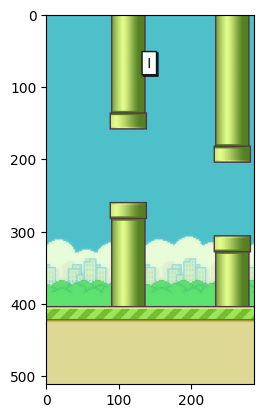

In [12]:
env.reset()
img = plt.imshow(env.render())
episode_lengths = []
for e in range(5):
    state = env.reset()[0]
    done = False
    counter = 0
    while not done:
        action = agent.act(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        state = next_state
        img.set_data(env.render()) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        counter += 1
    episode_lengths.append(counter)
print(f"All episode lengths: {episode_lengths}")
print(f"Average episode length: {np.mean(episode_lengths)}")
env.close()